In [72]:
import pandas as pd
import sqlite3
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from hockey_rink import IIHFRink
from shapely.geometry import Polygon 
from scipy.spatial import Voronoi


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import matplotlib as mpl

In [3]:
# Data Directory
data_dir = "../../Data/Big-Data-Cup-2021"
bucketless_data_dir = '../../Data/bdc/data'
tracking_data_dir = "{}/TrackingData".format(data_dir)
db_path = '/Users/keltim01/Documents/databases/'

#connect to database 
conn = sqlite3.connect(db_path + 'bdc_2022.db')
cursor = conn.cursor()

In [4]:
df_pbp_pp = pd.read_sql('SELECT * FROM play_by_play WHERE frame_id_1 IS NOT NULL AND strength_state > 0', conn) 

In [5]:
df_pbp_pp.shape

(861, 70)

In [6]:
df_pbp_pp.columns

Index(['level_0', 'index', 'game_date', 'season_year', 'team_name',
       'opp_team_name', 'venue', 'period', 'clock_seconds', 'situation_type',
       'goals_for', 'goals_against', 'player_name', 'event',
       'event_successful', 'x_coord', 'y_coord', 'event_type', 'player_name_2',
       'x_coord_2', 'y_coord_2', 'event_detail_1', 'event_detail_2',
       'event_detail_3', 'frame_id_1', 'frame_id_2', 'home_team', 'away_team',
       'game_id', 'is_shot', 'is_goal', 'event_id', 'team_id', 'player_id',
       'detail_1_code', 'goal_diff', 'game_seconds_remaining', 'event_code',
       'event_type_code', 'skaters_for', 'skaters_against', 'strength_state',
       'distance_to_goal', 'angle_to_goal', 'prev_event', 'prev_event_code',
       'prev_event_type', 'prev_event_type_code', 'prev_event_x_coord',
       'prev_event_y_coord', 'prev_event_game_seconds_remaining',
       'prev_event_distance_to_goal', 'prev_event_angle_to_goal',
       'time_diff_last_event', 'angle_diff_last_event

In [7]:
df_pbp_pp['x_coord_adj'] = df_pbp_pp['x_coord'].apply(lambda x: x-100)
df_pbp_pp['y_coord_adj'] = df_pbp_pp['y_coord'].apply(lambda x: x-42.5)
df_pbp_pp['x_end_coord_adj'] = df_pbp_pp['x_coord_2'].apply(lambda x: x-100)
df_pbp_pp['y_end_coord_adj'] = df_pbp_pp['y_coord_2'].apply(lambda x: x-42.5)

In [8]:
xT_net = np.loadtxt('data/xT_net.csv', delimiter=',')
xT = np.loadtxt('data/xT.csv', delimiter=',')
xT_against = np.loadtxt('data/xT_against.csv', delimiter=',')

In [9]:
df_pbp_pp_passes = df_pbp_pp[df_pbp_pp['event'] == 'Play'].copy()

In [10]:
df_pbp_pp_passes.loc[:,'y_start'] = pd.cut(df_pbp_pp_passes.loc[:,'y_coord_adj'], bins=9, labels=False)
df_pbp_pp_passes.loc[:,'x_start'] = pd.cut(df_pbp_pp_passes.loc[:,'x_coord_adj'], bins=16, labels=False)
df_pbp_pp_passes.loc[:,'y_end'] = pd.cut(df_pbp_pp_passes.loc[:,'y_end_coord_adj'], bins=9, labels=False)
df_pbp_pp_passes.loc[:,'x_end'] = pd.cut(df_pbp_pp_passes.loc[:,'x_end_coord_adj'], bins=16, labels=False)

In [11]:
df_pbp_pp_passes.shape

(504, 78)

In [12]:
df_pbp_pp_passes.event_successful.unique()

array([1, 0])

In [13]:
df_pbp_pp_passes.loc[(df_pbp_pp_passes["event_successful"] == 1), 'xT'] = df_pbp_pp_passes.loc[df_pbp_pp_passes["event_successful"] == 1].apply(lambda row: xT[row.y_end][row.x_end] - xT[row.y_start][row.x_start], axis = 1)
df_pbp_pp_passes.loc[(df_pbp_pp_passes["event_successful"] == 0), 'xT'] = df_pbp_pp_passes.loc[df_pbp_pp_passes["event_successful"] == 0].apply(lambda row: -xT[row.y_start][row.x_start], axis = 1)
df_pbp_pp_passes.loc[(df_pbp_pp_passes["event_successful"] == 1), 'xT_against'] = df_pbp_pp_passes.loc[df_pbp_pp_passes["event_successful"] == 1].apply(lambda row: xT_against[row.y_end][row.x_end] - xT_against[row.y_start][row.x_start], axis = 1)
df_pbp_pp_passes.loc[(df_pbp_pp_passes["event_successful"] == 0), 'xT_against'] = df_pbp_pp_passes.loc[df_pbp_pp_passes["event_successful"] == 0].apply(lambda row: xT_against[row.y_start][row.x_start], axis = 1)
df_pbp_pp_passes['xT_net'] = df_pbp_pp_passes['xT'] + df_pbp_pp_passes['xT_against']

In [14]:
df_plot_xt_net_passes = df_pbp_pp_passes.sort_values(by=['xT_net'], ascending=False).head(10)

In [15]:
df_plot_xt_passes = df_pbp_pp_passes.sort_values(by=['xT'], ascending=False).head(20)

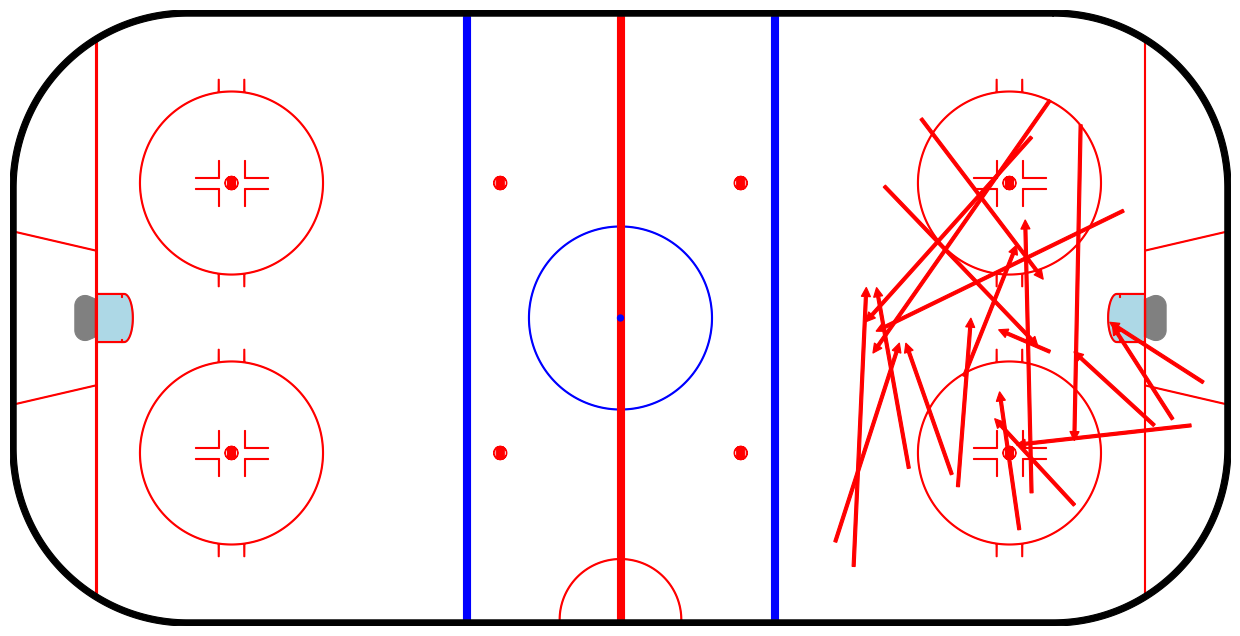

In [16]:
rink = IIHFRink()

fig, ax = plt.subplots(figsize=(18, 8))

text_color = "black"
background = "white"
edge = "white"
sns.set_context("paper")
#fig.text(0.15,0.9,'net expected Threat: {}, lane crossing blue line: {} ,lane exit location: {}'.format(round(plot_xT_net,4), plot_exit_lane_int, plot_exit_lane_loc), fontweight='regular',fontsize=18,color=text_color)


rink.arrow(data=df_plot_xt_passes, x='x_coord_adj', y='y_coord_adj', x2='x_end_coord_adj', y2='y_end_coord_adj', ax=ax, color='red', width=0.5, head_width=1.5, head_length=1.5)
#rink.plot_fn(sns.scatterplot, x="xadjcoord", y="yadjcoord", s=100, legend=False, data=df_plot_exit[df_plot_exit['eventname'] == 'controlledexit'], ax=ax)
# for i,row in df_plot_xt_net_passes-.iterrows():
#     ax.annotate(row['eventname'], xy=(row['xadjcoord'], row['yadjcoord']), size=14, rotation=-20)

plt.show()


In [17]:
df_pbp_pp_passes.columns

Index(['level_0', 'index', 'game_date', 'season_year', 'team_name',
       'opp_team_name', 'venue', 'period', 'clock_seconds', 'situation_type',
       'goals_for', 'goals_against', 'player_name', 'event',
       'event_successful', 'x_coord', 'y_coord', 'event_type', 'player_name_2',
       'x_coord_2', 'y_coord_2', 'event_detail_1', 'event_detail_2',
       'event_detail_3', 'frame_id_1', 'frame_id_2', 'home_team', 'away_team',
       'game_id', 'is_shot', 'is_goal', 'event_id', 'team_id', 'player_id',
       'detail_1_code', 'goal_diff', 'game_seconds_remaining', 'event_code',
       'event_type_code', 'skaters_for', 'skaters_against', 'strength_state',
       'distance_to_goal', 'angle_to_goal', 'prev_event', 'prev_event_code',
       'prev_event_type', 'prev_event_type_code', 'prev_event_x_coord',
       'prev_event_y_coord', 'prev_event_game_seconds_remaining',
       'prev_event_distance_to_goal', 'prev_event_angle_to_goal',
       'time_diff_last_event', 'angle_diff_last_event

In [18]:
df_pbp_pp_passes.groupby(['player_id', 'player_name']).agg({'xT': ['mean', 'sum', 'count']}).sort_values(by=('xT', 'mean'), ascending=False).head(50)

xT                    
                                      mean           sum count
player_id player_name                                         
77        Petra Nieminen      8.495927e-03  5.097556e-02     6
65        Michelle Karvinen   8.175250e-03  7.357725e-02     9
102       Viivi Vainikka      6.342885e-03  4.440020e-02     7
45        Keely Moy           4.500911e-03  9.001821e-03     2
22        Dominique Ruegg     3.997408e-03  4.397149e-02    11
1         Abby Roque          3.246508e-03  3.895809e-02    12
87        Sarah Fillier       2.837935e-03  8.513804e-03     3
30        Evelina Raselli     2.568262e-03  2.825088e-02    11
7         Amanda Kessel       1.834601e-03  2.935361e-02    16
17        Brianne Jenner      1.554541e-03  3.109083e-03     2
85        Sanni Rantala       1.504670e-03  7.523352e-03     5
38        Jenniina Nylund     1.376222e-03  1.376222e-03     1
91        Savannah Harmon     1.251557e-03  1.752180e-02    14
69        Nelli Laitinen      1.065387e-03  2.983084e-02    28
64        Mich Zandee-Hart    1.043260e-03  1.043260e-03     1
72        Nina Pirogova       9.088421e-04  7.270737e-03     8
42        Jocelyne Larocque   9.026334e-04  2.707900e-03     3
78        Phoebe Staenz       8.146099e-04  4.073049e-03     5
100       Valeria Pavlova     7.754214e-04  2.326264e-03     3
13        Anna Shokhina       7.176414e-04  7.176414e-03    10
29        Erin Ambrose        7.039715e-04  4.927801e-03     7
81        Rebecca Johnston    6.025613e-04  3.012807e-03     5
35        Hilary Knight       5.616338e-04  2.808169e-03     5
66        Minnamari Tuominen  4.842689e-04  1.259099e-02    26
19        Cayla Barnes        4.803549e-04  5.283904e-03    11
74        Noora Tulus         4.631276e-04  3.241893e-03     7
6         Alina Muller        4.431765e-04  9.306706e-03    21
4         Alexandra Vafina    4.319580e-04  1.295874e-03     3
50        Lara Stalder        3.817349e-04  8.016432e-03    21
41        Jincy Dunne         3.395196e-04  1.697598e-03     5
90        Saskia Maurer       2.567904e-04  1.027162e-03     4
75        Olga Sosina         2.417213e-04  2.900655e-03    12
97        Susanna Tapani      2.400116e-04  2.400116e-04     1
2         Alex Carpenter      2.176744e-04  2.394418e-03    11
37        Jenni Hiirikoski    1.172760e-04  1.641865e-03    14
14        Anni Keisala        9.397632e-05  4.698816e-04     5
21        Dani Cameranesi     7.430560e-05  2.972224e-04     4
11        Anna Savonina       5.186872e-05  2.074749e-04     4
57        Maddie Rooney       4.829625e-07  4.829625e-07     1
99        Valeria Merkusheva  0.000000e+00  0.000000e+00     3
3         Alex Cavallini     -1.498940e-07 -2.997880e-07     2
10        Ann-Renee Desbiens -2.160306e-07 -2.160306e-07     1
8         Andrea Brandli     -5.894418e-07 -4.715534e-06     8
68        Natalie Spooner    -4.718370e-05 -9.436740e-05     2
46        Kelly Pannek       -8.551729e-05 -3.420692e-04     4
71        Nicole Vallario    -1.530550e-04 -1.530550e-03    10
92        Shannon Sigrist    -1.692188e-04 -1.692188e-04     1
23        Elisa Holopainen   -1.830991e-04 -3.661981e-03    20
49        Lara Christen      -2.305355e-04 -7.607673e-03    33
94        Sinja Leemann      -2.809433e-04 -4.214149e-03    15

In [19]:
df_tracking = pd.read_sql('SELECT * FROM tracking', conn)

In [20]:
df_tracking.head()

,level_0,index,frame_id,period,track_id,team_id,team_name,jersey_number,x_coord,y_coord,video_shot,game_seconds,venue,player,position,game_id,x_coord_adj,y_coord_adj,frame_id_unique,area
0,0,0,96,1,2,Light,ROC,100,176.651307,52.308133,1,2590,away,None,None,4,76.651307,9.808133,96_1_4,1698.965885
1,1,1,96,1,3,Light,ROC,27,158.782222,41.325801,1,2590,away,Veronika Korzhakova,Center,4,58.782222,-1.174199,96_1_4,1819.654965
2,2,2,96,1,4,Dark,Finland,10,151.138502,51.883526,1,2590,home,Elisa Holopainen,Left Wing,4,51.138502,9.383526,96_1_4,312.640948
3,3,3,96,1,5,Light,ROC,100,163.814533,59.253376,1,2590,away,None,None,4,63.814533,16.753376,96_1_4,2010.684087
4,4,4,96,1,8,Dark,Finland,88,165.000000,50.000000,1,2590,home,Ronja Savolainen,Defense,4,65.000000,7.500000,96_1_4,79.319865


In [21]:
df_pbp_pp_passes.head()

,level_0,index,game_date,season_year,team_name,opp_team_name,venue,period,clock_seconds,situation_type,goals_for,goals_against,player_name,event,event_successful,x_coord,y_coord,event_type,player_name_2,x_coord_2,y_coord_2,event_detail_1,event_detail_2,event_detail_3,frame_id_1,frame_id_2,home_team,away_team,game_id,is_shot,is_goal,event_id,team_id,player_id,detail_1_code,goal_diff,game_seconds_remaining,event_code,event_type_code,skaters_for,skaters_against,strength_state,distance_to_goal,angle_to_goal,prev_event,prev_event_code,prev_event_type,prev_event_type_code,prev_event_x_coord,prev_event_y_coord,prev_event_game_seconds_remaining,prev_event_distance_to_goal,prev_event_angle_to_goal,time_diff_last_event,angle_diff_last_event,distance_diff_last_event,second_prev_event,second_prev_event_code,second_prev_event_type,second_prev_event_type_code,second_prev_event_x_coord,second_prev_event_y_coord,second_prev_event_game_seconds_remaining,second_prev_event_distance_to_goal,second_prev_event_angle_to_goal,prev_time_diff_last_event,prev_angle_diff_last_event,prev_distance_diff_last_event,non_shot_expected_goals,expected_goals,x_coord_adj,y_coord_adj,x_end_coord_adj,y_end_coord_adj,y_start,x_start,y_end,x_end,xT,xT_against,xT_net
0,441,441,8/2/2022,2021,Olympic (Women) - Canada,Olympic (Women) - United States,away,1,375,5 on 4,0,0,Brianne Jenner,Play,1,185,7,Direct,Marie-Philip Poulin,139.0,5.0,None,0,0,344.0,370.0,Olympic (Women) - United States,Olympic (Women) - Canada,5,0,0,3,0,17,-1,0,2775.0,3,6,5,4,1,35.850384,0.140845,Play,3.0,Indirect,15.0,194.0,66.0,2778.0,23.837995,-0.170213,-3.0,0.311058,12.012389,Puck Recovery,4.0,None,-1.0,165.0,82.0,2780.0,46.746658,0.632911,-2.0,-0.803124,-22.908663,0.189897,NaN,85,-35.5,39.0,-37.5,0,14,0,11,0.000128,0.000244,0.000372
1,442,442,8/2/2022,2021,Olympic (Women) - Canada,Olympic (Women) - United States,away,1,373,5 on 4,0,0,Marie-Philip Poulin,Play,1,161,3,Direct,Rebecca Johnston,143.0,19.0,None,0,0,420.0,443.0,Olympic (Women) - United States,Olympic (Women) - Canada,5,0,0,3,0,60,-1,0,2773.0,3,6,5,4,1,49.002551,0.734177,Play,3.0,Direct,6.0,185.0,7.0,2775.0,35.850384,0.140845,-2.0,0.593332,13.152167,Play,3.0,Indirect,15.0,194.0,66.0,2778.0,23.837995,-0.170213,-3.0,0.311058,12.012389,0.189897,NaN,61,-39.5,43.0,-23.5,0,12,1,11,0.000834,0.000366,0.001200
2,443,443,8/2/2022,2021,Olympic (Women) - Canada,Olympic (Women) - United States,away,1,366,5 on 4,0,0,Rebecca Johnston,Play,1,176,3,Direct,Marie-Philip Poulin,130.0,17.0,None,0,0,605.0,639.0,Olympic (Women) - United States,Olympic (Women) - Canada,5,0,0,3,0,81,-1,0,2766.0,3,6,5,4,1,41.907637,0.354430,Play,3.0,Direct,6.0,161.0,3.0,2773.0,49.002551,0.734177,-7.0,-0.379747,-7.094914,Play,3.0,Direct,6.0,185.0,7.0,2775.0,35.850384,0.140845,-2.0,0.593332,13.152167,0.189897,NaN,76,-39.5,30.0,-25.5,0,14,1,10,0.001057,0.000438,0.001495
3,444,444,8/2/2022,2021,Olympic (Women) - Canada,Olympic (Women) - United States,away,1,365,5 on 4,0,0,Marie-Philip Poulin,Play,1,130,17,Direct,Erin Ambrose,133.0,55.0,None,0,0,650.0,670.0,Olympic (Women) - United States,Olympic (Women) - Canada,5,0,0,3,0,60,-1,0,2765.0,3,6,5,4,1,65.193941,2.352941,Play,3.0,Direct,6.0,176.0,3.0,2766.0,41.907637,0.354430,-1.0,1.998511,23.286305,Play,3.0,Direct,6.0,161.0,3.0,2773.0,49.002551,0.734177,-7.0,-0.379747,-7.094914,0.189897,NaN,30,-25.5,33.0,12.5,1,10,5,10,0.000129,0.000006,0.000135
4,445,445,8/2/2022,2021,Olympic (Women) - Canada,Olympic (Women) - United States,away,1,363,5 on 4,0,0,Erin Ambrose,Play,1,139,55,Direct,Brianne Jenner,176.0,42.0,None,0,0,701.0,718.0,Olympic (Women) - United States,Olympic (Women) - Canada,5,0,0,3,0,29,-1,0,2763.0,3,6,5,4,1,52.509523,4.080000,Play,3.0,Direct,6.0,130.0,17.0,2765.0,65.193941,2.352941,-2.0,1.727059,-12.684418,Play,3.0,Direct,6.0,176.0,3.0,2766.0,41.907637,0.354430,-1.0,1.998511,23.286305,0.189897,NaN,39,12.5,76.0,-0.5,5,11,4,14,0.005361,-0.000003,0.005358


In [22]:
df_pbp_pp_passes_succ = df_pbp_pp_passes.loc[df_pbp_pp_passes["event_successful"] == 1].copy()

In [24]:
df_tracking.head()

,level_0,index,frame_id,period,track_id,team_id,team_name,jersey_number,x_coord,y_coord,video_shot,game_seconds,venue,player,position,game_id,x_coord_adj,y_coord_adj,frame_id_unique,area
0,0,0,96,1,2,Light,ROC,100,176.651307,52.308133,1,2590,away,None,None,4,76.651307,9.808133,96_1_4,1698.965885
1,1,1,96,1,3,Light,ROC,27,158.782222,41.325801,1,2590,away,Veronika Korzhakova,Center,4,58.782222,-1.174199,96_1_4,1819.654965
2,2,2,96,1,4,Dark,Finland,10,151.138502,51.883526,1,2590,home,Elisa Holopainen,Left Wing,4,51.138502,9.383526,96_1_4,312.640948
3,3,3,96,1,5,Light,ROC,100,163.814533,59.253376,1,2590,away,None,None,4,63.814533,16.753376,96_1_4,2010.684087
4,4,4,96,1,8,Dark,Finland,88,165.000000,50.000000,1,2590,home,Ronja Savolainen,Defense,4,65.000000,7.500000,96_1_4,79.319865


In [63]:
count = 0
df_pbp_pp_passes_succ['area'] = np.nan
for index, row in df_pbp_pp_passes_succ.iterrows():
    _df = df_tracking.loc[(df_tracking['game_id'] == row['game_id']) & (df_tracking['period'] == row['period']) & (df_tracking['frame_id'] == row['frame_id_2']) & (df_tracking['player'] == row['player_name_2']),:].copy()
    if (_df.empty == False) & (~_df['area'].isnull().any()):
            df_pbp_pp_passes_succ.loc[index,'area'] = _df['area'].values[0]
            count += 1
    
    


In [50]:
count

20

In [65]:
df_pbp_pp_passes_succ['area'].isnull().sum(), df_pbp_pp_passes_succ.shape

(420, (440, 82))

In [67]:
df_pbp_pp_passes_plot = df_pbp_pp_passes_succ.dropna(subset=['area']).sort_values(by=['xT'], ascending=False).head(1)

In [69]:
def calculate_voronoi(dfTemp):
  values = np.vstack((dfTemp[['x_coord_adj','y_coord_adj']].values,
                      [10,-42.5],
                      [10,+42.5],
                      [130,-42.5],
                      [130,42.5],
                      [10,0],
                      [130,0],
                      ))
  vor = Voronoi(values)

  dfTemp['region'] = vor.point_region[:-6]

  return vor, dfTemp

In [70]:
direction = -1
def draw_voronoi(dfFrame):
  vor, dfVor = calculate_voronoi(dfFrame)
  for index, region in enumerate(vor.regions): 
      if not -1 in region: 
          if len(region)>0: 
            try: 
              pl = dfVor.loc[dfVor['region']==index]
              polygon = Polygon([vor.vertices[i] for i in region])
              if pl['venue'].values[0]=='home':
                color = 'b'
              else:
                color = 'r'
              x,y = polygon.exterior.xy
              plt.fill(x,y, c=color , alpha=0.2)
            except IndexError:
              pass
            except AttributeError: 
              pass
  return fig, ax, dfFrame

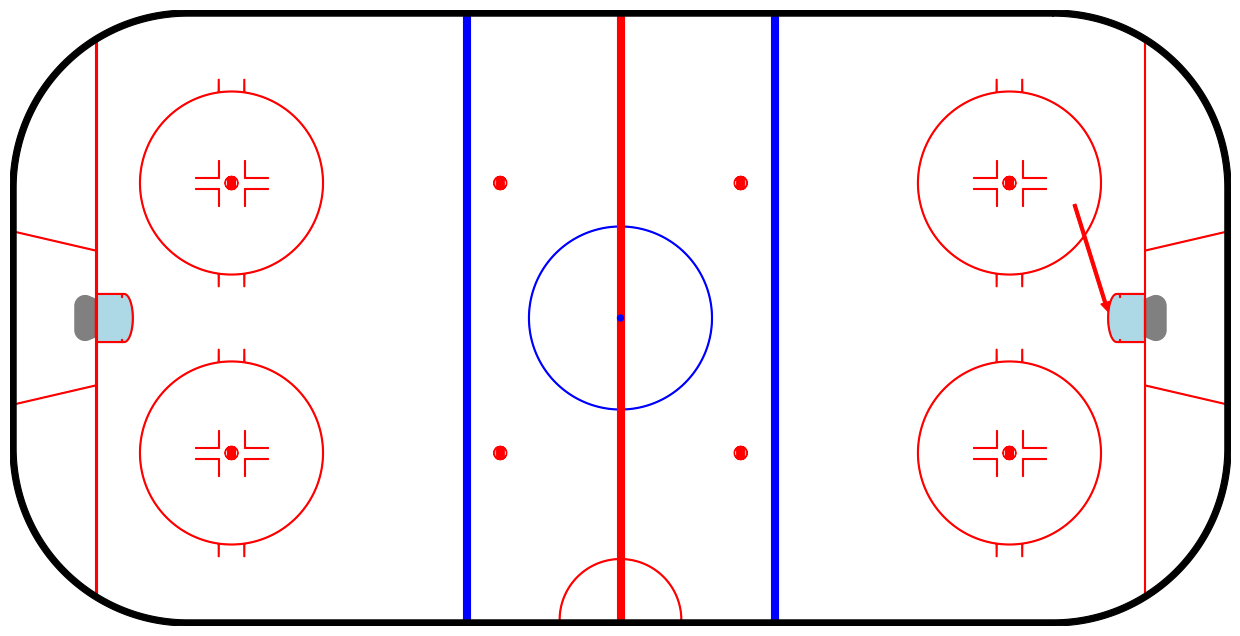

In [68]:
rink = IIHFRink()

fig, ax = plt.subplots(figsize=(18, 8))

text_color = "black"
background = "white"
edge = "white"
sns.set_context("paper")
#fig.text(0.15,0.9,'net expected Threat: {}, lane crossing blue line: {} ,lane exit location: {}'.format(round(plot_xT_net,4), plot_exit_lane_int, plot_exit_lane_loc), fontweight='regular',fontsize=18,color=text_color)


rink.arrow(data=df_pbp_pp_passes_plot, x='x_coord_adj', y='y_coord_adj', x2='x_end_coord_adj', y2='y_end_coord_adj', ax=ax, color='red', width=0.5, head_width=1.5, head_length=1.5)
#rink.plot_fn(sns.scatterplot, x="xadjcoord", y="yadjcoord", s=100, legend=False, data=df_plot_exit[df_plot_exit['eventname'] == 'controlledexit'], ax=ax)
# for i,row in df_plot_xt_net_passes-.iterrows():
#     ax.annotate(row['eventname'], xy=(row['xadjcoord'], row['yadjcoord']), size=14, rotation=-20)

plt.show()

In [ ]:
df_tracking

In [30]:
_df

,level_0,index,frame_id,period,track_id,team_id,team_name,jersey_number,x_coord,y_coord,video_shot,game_seconds,venue,player,position,game_id,x_coord_adj,y_coord_adj,frame_id_unique,area
322541,322541,18940,2606,1,49,Dark,USA,21,7.881124,30.156893,2,2529,home,Hilary Knight,Center,5,-92.118876,-12.343107,2606_1_5,NaN
